In [15]:
import cv2
import numpy as np
from scipy.ndimage import rotate
from os import listdir
from os.path import isfile, join
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import pandas as pd

In [3]:
def extract(fname):
    image = cv2.imread(fname)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # key is to find a binary template before findContours!
    # one option is hsv sat (0, 70)
    sat = hsv[:, :, 1]
    sat = cv2.medianBlur(sat, ksize = 3)
    sat1 = cv2.inRange(sat, (0), (60))/255

    rmask = cv2.inRange(image[:, :, 0], (100), (255))/255
    return sat1, rmask

[1, 4, 1, 1, 2, 1, 5, 1, 2, 899, 1]
(899, 1, 2)
(899, 2)
DSC00839


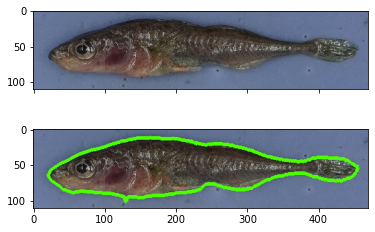

In [17]:
# using the findcoutours in opencv: 
path = "../data/CC Lake extracted/5/"
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

for f in onlyfiles[:1]:
# for i in ['DSC00840.jpg', 'DSC00841.jpg', 'DSC00842.jpg', 'DSC00843.jpg']:
    path = "../data/CC Lake extracted/5/"
    sat1, rmask = extract(join(path, f))
    image = cv2.imread(join(path, f))

    comb = np.uint8(np.maximum(sat1, 1-rmask)*255)
    contours, hierarchy  = cv2.findContours(comb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # get the largest contour element
    cont_dim = []
    for i in contours: 
        cont_dim.append(i.shape[0])
    print(cont_dim)
    idx = np.argmax(cont_dim)
    points = contours[np.argmax(cont_dim)]
    print(points.shape)
    print(np.squeeze(points, axis=1).shape)
    img1 = cv2.drawContours(np.copy(image), points, -1, (0,255,75), 3)
    
    fig, (ax1, ax4) = plt.subplots(2, 1, sharex=True)
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax4.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    
    outpath = "../data/contour/findcontour/"
    print(f[:-4])
    outpathcsv = "../data/contour/findcontour_csv/"
    pd.DataFrame(np.squeeze(points, axis=1)).to_csv(join(outpathcsv, f[:-4]+".csv"), index = False, header = False)
#     np.savetxt(join(outpathcsv, f[:-4]+".csv"), np.squeeze(points, axis=1), delimiter=",")
    cv2.imwrite(join(outpath, f), img1)

[[[164, 30]], [[163, 31]], [[162, 31]], [[161, 31]], [[160, 31]], [[159, 31]], [[158, 31]], [[157, 31]], [[156, 31]], [[155, 31]], [[154, 31]], [[153, 31]], [[152, 32]], [[151, 32]], [[150, 32]], [[149, 32]], [[148, 32]], [[147, 32]], [[146, 33]], [[145, 33]], [[144, 33]], [[143, 33]], [[142, 33]], [[141, 34]], [[140, 34]], [[139, 34]], [[138, 34]], [[137, 34]], [[136, 34]], [[135, 35]], [[134, 35]], [[133, 35]], [[132, 35]], [[131, 36]], [[130, 36]], [[129, 36]], [[128, 36]], [[127, 36]], [[126, 37]], [[125, 37]], [[124, 37]], [[123, 38]], [[122, 38]], [[121, 38]], [[120, 38]], [[119, 39]], [[118, 39]], [[117, 39]], [[116, 39]], [[115, 39]], [[114, 40]], [[113, 40]], [[112, 40]], [[111, 40]], [[110, 41]], [[109, 41]], [[108, 42]], [[107, 41]], [[106, 42]], [[105, 42]], [[104, 42]], [[103, 42]], [[102, 43]], [[101, 43]], [[100, 43]], [[99, 43]], [[98, 43]], [[97, 43]], [[96, 43]], [[95, 43]], [[94, 44]], [[93, 44]], [[92, 44]], [[91, 44]], [[90, 44]], [[89, 45]], [[88, 45]], [[87, 45]]

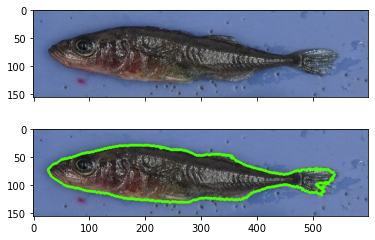

In [20]:
#get the contour result
path = "../data/CC Lake extracted/5/"
fname = 'DSC00840.jpg'

sat1, rmask = extract(join(path, f))
image = cv2.imread(join(path, f))
comb = np.uint8(np.maximum(sat1, 1-rmask)*255)

contours, hierarchy = cv2.findContours(comb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(contours[-3][:100, :,:].tolist())
print(contours[-3].shape)
img1 = cv2.drawContours(np.copy(image), contours[-3], -1, (0,255,75), 3)
    
fig, (ax1, ax4) = plt.subplots(2, 1, sharex=True)
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax4.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
outpath = "../data/contour/findcontour/"


In [ ]:
# using skimage active contour
for i in ['DSC00840.jpg', 'DSC00841.jpg', 'DSC00842.jpg', 'DSC00843.jpg'][:1]:
    path = "../data/CC Lake extracted/2/"
    sat1, rmask = extract(join(path, f))
    image = cv2.imread(join(path, f))
    comb = np.uint8(np.maximum(sat1, 1-rmask)*255)  
    # try 1000 points to initiate
    r, c = image.shape[:2]
    initx = np.linspace(0, c, num = 400+1, endpoint = True)
    inity = np.linspace(0, r, num = 100+1, endpoint = True)

    init_top = np.array([np.zeros(400), initx[:400]]).T
    init_right = np.array([inity[:100], np.ones(100)*(c-1)]).T
    init_bot = np.array([np.ones(400)*(r-1), initx[1:]]).T
    init_left = np.array([inity[1:], np.zeros(100)]).T
    init = np.vstack((init_top, init_right, init_bot, init_left))

    for a in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]: 
        for b in [0.001, 0.01, 0.1, 1, 5, 10]: 
            for g in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]: 
                snake = active_contour(gaussian(comb, 3, preserve_range=False), init, 
                                       alpha=a, beta=b, gamma=b)
    
                print(a, b, g)
                fig, ax = plt.subplots(figsize=(7, 7))
                ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
                ax.plot(init[:, 1], init[:, 0], '.r', lw=3)
                ax.plot(snake[:, 1], snake[:, 0], '.b', lw=3)
                ax.set_xticks([]), ax.set_yticks([])
                ax.axis([0, image.shape[1], image.shape[0], 0])
                plt.show()

# good ones: 0.001 0.001 0.001 through 0.001 0.001 1; 
# 0.005 0.001 0.001 through 0.005 0.001 1; 0.05 0.001 0.001 through 0.05 0.001 1, no tail
# wrong test, now gamma = beta.... small alpha, small beta

In [ ]:
# less points, now 500, namely 250 + 50
for i in ['DSC00840.jpg', 'DSC00841.jpg', 'DSC00842.jpg', 'DSC00843.jpg'][:1]:
    path = "../data/CC Lake extracted/2/"
    sat1, rmask = extract(join(path, f))
    image = cv2.imread(join(path, f))
    comb = np.uint8(np.maximum(sat1, 1-rmask)*255)
    
    # try 1000 points to initiate
    r, c = image.shape[:2]
    initx = np.linspace(0, c, num = 200+1, endpoint = True)
    inity = np.linspace(0, r, num = 50+1, endpoint = True)

    init_top = np.array([np.zeros(200), initx[:200]]).T
    init_right = np.array([inity[:50], np.ones(50)*(c-1)]).T
    init_bot = np.array([np.ones(200)*(r-1), initx[1:]]).T
    init_left = np.array([inity[1:], np.zeros(50)]).T
    init = np.vstack((init_top, init_right, init_bot, init_left))
    gamma = 0.001
    for a in [0.001]: 
        for b in [0.01]: 
            for g in [0.0001, 0.001, 0.01, 0.05, 0.1, 1]: 
                snake = active_contour(gaussian(comb, 3, preserve_range=False), init, 
                                           alpha=a, beta=b, gamma=g)

                print(a, b)
                fig, ax = plt.subplots(figsize=(7, 7))
                ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap=plt.cm.gray)
                ax.plot(init[:, 1], init[:, 0], '.r', lw=3)
                ax.plot(snake[:, 1], snake[:, 0], '.b', lw=3)
                ax.set_xticks([]), ax.set_yticks([])
                ax.axis([0, image.shape[1], image.shape[0], 0])
                plt.show()
# good ones: 0.001 0.001 through 0.001, 0.01; best g 0.001

In [ ]:
# try other contour method: 